# Practice Goals for this Version:

In the next few versions I want to make one small change to the notebook and see how it effects the result. This is in line with the "Edysonian" approach of iterative testing.

Some of the things I'll test in the next few versions:
1. Changing scaling algorithm to standard scaler.
2. Changing age imputation to title+Pclass.
3. Training SVM over xgb.
5. Delete n_of_rel feature.
6. Delete has cabin or not feature.
7. Delete embarked feature.
8. Fix the merging and splitting of the test/ training set to keep its independence.

This version will check changes in the scaling algorithm.

# Debrief
1. Changing scaling algorithm has exactly zero difference in results. I'd still presume robust scaler is better because some of the data is skewed.
2. I had to create title feature, which I dropped (in future I could one-hot encode it). The test score actually became a bit worse, let's see how it does on the competition data. Surprisingly, it also produced a worse competition score. What I would try next is to fine-tune SVM instead.
3. The first thing I've learned is that svm is much much longer than xgboost and others models to train. I would've switched back to xgb, but this run resulted in the best score so far of 77.5, which is at least 1% more than my best previous score. But, I also made one mistake with the age imputation for one passenger, so maybe this is what influenced this 1% score. I'm rerunning 4.2 to see if it is the case. Checked, no I still got worse result, so SVM is actually better.
4. Surprisingly, got slighly better result (0.04%), could be overfitting, but let's see what happens if I continue to delete a few feature and how the results are impacted.
5. Yep, now results fall back by 0.02%. Let's see one last time how deleting embarked feature impacts the results.

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load


import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pandas import Series, DataFrame
import matplotlib.pyplot as plt

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


import matplotlib.pyplot as plt

plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


In [2]:
train = pd.read_csv("/kaggle/input/titanic/train.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
test = pd.read_csv("/kaggle/input/titanic/test.csv")
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [4]:
gen_sub = pd.read_csv("/kaggle/input/titanic/gender_submission.csv")
gen_sub.head()

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1


# Data Exploration

In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [6]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.1+ KB


<Axes: ylabel='Frequency'>

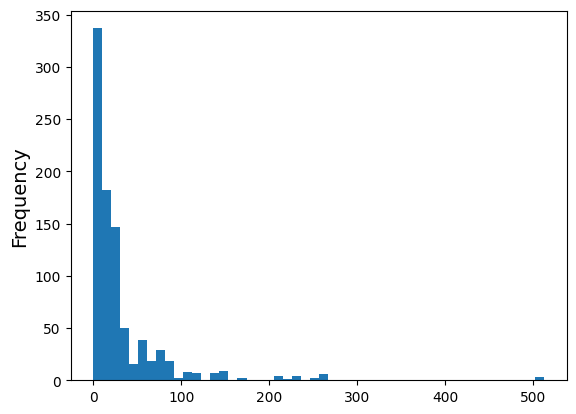

In [7]:
train.Fare.plot(kind="hist", bins=50)

<Axes: ylabel='Frequency'>

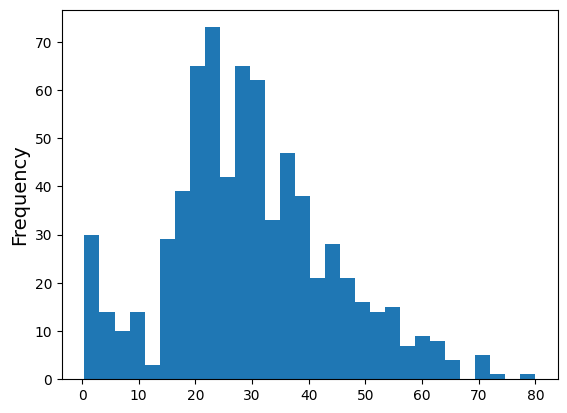

In [8]:
train.Age.plot(kind="hist", bins=30)
#train.Parch.plot(kind="hist", bins=30)
#train.SibSp.plot(kind="hist", bins=30)

<Axes: xlabel='Pclass'>

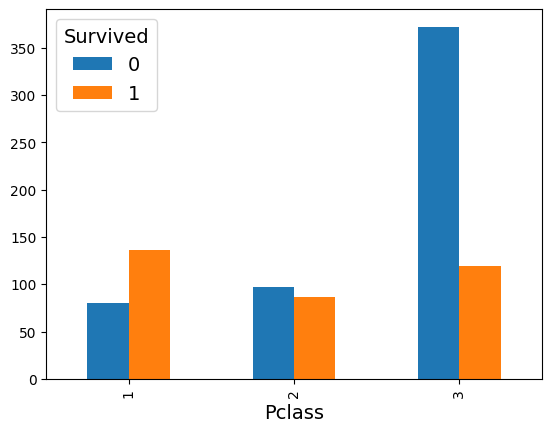

In [9]:
#train.plot(x="Survived", y="Pclass", kind="scatter")
#pd.crosstab(train.Pclass, train.Survived)
counts = train.groupby(["Pclass", "Survived"]).size().unstack()
counts.plot(kind="bar")

<Axes: xlabel='Embarked'>

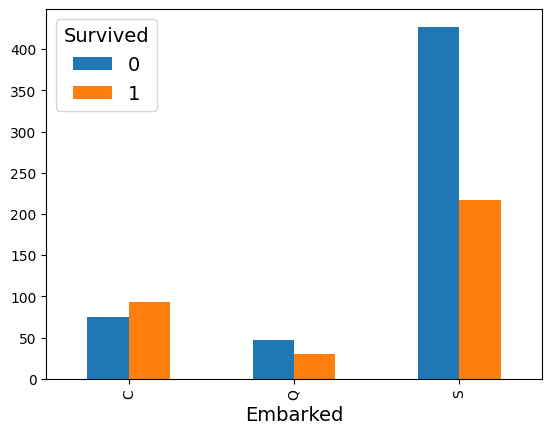

In [10]:
counts = train.groupby(["Embarked", "Survived"]).size().unstack()
counts.plot(kind="bar")

<Axes: xlabel='Parch'>

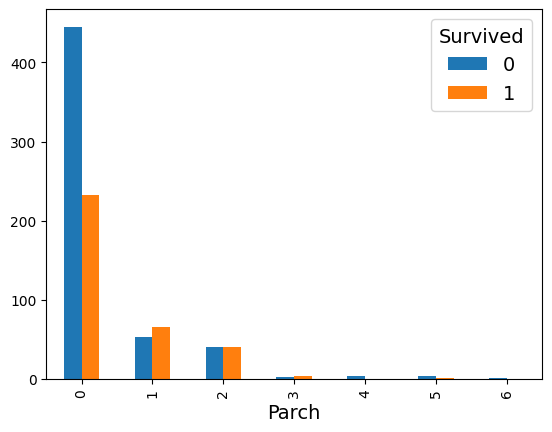

In [11]:
counts = train.groupby(["Parch", "Survived"]).size().unstack()
counts.plot(kind="bar")
# seems like it helps to have family members

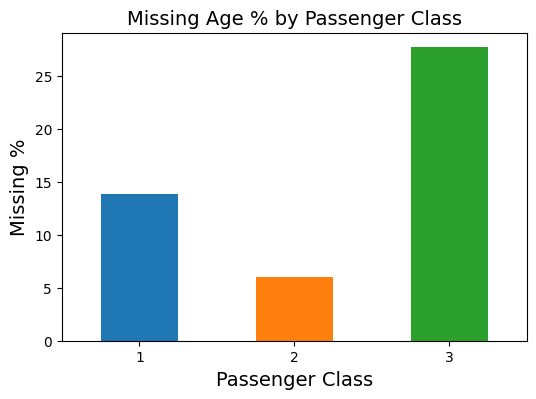

Pclass
1    13.888889
2     5.978261
3    27.698574
Name: Age, dtype: float64


In [12]:
# Does missing age correlates with the class passenger is in?

# Calculate missing age percentage by class
missing_pct = train.groupby('Pclass')['Age'].apply(lambda x: x.isna().mean() * 100)

# Plot it
missing_pct.plot(kind='bar', figsize=(6, 4), color=['#1f77b4', '#ff7f0e', '#2ca02c'])
plt.title('Missing Age % by Passenger Class')
plt.xlabel('Passenger Class')
plt.ylabel('Missing %')
plt.xticks(rotation=0)
plt.show()

print(missing_pct)

# Handle Missing Values

Previously for handling missing age values I used simple median across all train and test sets, now we'll use more sophisticated approaches. 

Specifically, we'll first merge train and test sets, then group passengers by sex and class, and then impute the mean of each group. 

(In the future versions final improvement we'll be using extracted titles from names.)

In [13]:
# Merging datasets.
combined = pd.concat([train, test], axis=0, ignore_index=True)
combined.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [14]:
# Step 1: Extract titles from the Name column
combined['Title'] = combined['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)

# Step 2: Group titles
TitleDict = {"Capt": "Officer","Col": "Officer","Major": "Officer","Jonkheer": "Royalty", \
             "Don": "Royalty", "Sir" : "Royalty","Dr": "Royalty","Rev": "Royalty", \
             "Countess":"Royalty", "Mme": "Mrs", "Mlle": "Miss", "Ms": "Mrs","Mr" : "Mr", \
             "Mrs" : "Mrs","Miss" : "Miss","Master" : "Master","Lady" : "Royalty"}

# Map titles to categories
combined['Title'] = combined['Title'].map(TitleDict)

# Step 3: Calculate mean age by Title and Pclass groups
age_stats = combined.groupby(['Title', 'Pclass'])['Age'].agg(['mean', 'count', 'std'])
print(age_stats)

                     mean  count        std
Title   Pclass                             
Master  1        6.984000      5   4.974061
        2        2.757273     11   2.723942
        3        6.090000     37   4.152566
Miss    1       30.131148     61  11.528914
        2       20.717083     48  12.207963
        3       17.360874    103   9.935434
Mr      1       41.450758    132  13.489020
        2       32.346715    137  11.862038
        3       28.318910    312   9.907858
Mrs     1       42.926471     68  14.122403
        2       33.418182     55  10.422005
        3       32.326531     49  10.194745
Officer 1       54.714286      7   8.440266
Royalty 1       43.600000     10   7.441625
        2       40.700000     10  12.927576


In [15]:
# Impute missing ages
combined['Age'] = combined.groupby(['Title', 'Pclass'])['Age'].transform(lambda x: x.fillna(x.mean()))

# Check if imputation worked
print(f"Missing ages: {combined['Age'].isnull().sum()}")

Missing ages: 1


In [16]:
display(combined[combined.Title.isnull()])

/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.11/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title
1305,1306,NaN,1,"Oliva y Ocana, Dona. Fermina",female,NaN,0,0,PC 17758,108.9,C105,C,NaN


In [17]:
combined.at[1305,'Title'] = 'Royalty'
combined.at[1305,'Age'] = 43.6

In [18]:
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1309 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Cabin        295 non-null    object 
 11  Embarked     1307 non-null   object 
 12  Title        1309 non-null   object 
dtypes: float64(3), int64(4), object(6)
memory usage: 133.1+ KB


Cabin will be converted to binary "has cabin". Which will have to be numeric 0/1.

In [19]:
#combined['HasCabin'] = combined['Cabin'].notna().astype(int)
combined = combined.drop('Cabin', axis=1)

combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1309 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1308 non-null   float64
 10  Embarked     1307 non-null   object 
 11  Title        1309 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


Missing fare instances will be replaced with median, while missing embarked with mode.

In [20]:
embarked_mode = combined['Embarked'].mode()[0]  # mode() returns a Series, so we take first value
combined['Embarked'].fillna(embarked_mode, inplace=True)
combined['Fare'].fillna(combined['Fare'].median(), inplace=True)

combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  1309 non-null   int64  
 1   Survived     891 non-null    float64
 2   Pclass       1309 non-null   int64  
 3   Name         1309 non-null   object 
 4   Sex          1309 non-null   object 
 5   Age          1309 non-null   float64
 6   SibSp        1309 non-null   int64  
 7   Parch        1309 non-null   int64  
 8   Ticket       1309 non-null   object 
 9   Fare         1309 non-null   float64
 10  Embarked     1309 non-null   object 
 11  Title        1309 non-null   object 
dtypes: float64(3), int64(4), object(5)
memory usage: 122.8+ KB


/tmp/ipykernel_36/2776746238.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  combined['Embarked'].fillna(embarked_mode, inplace=True)
/tmp/ipykernel_36/2776746238.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', 

# Feature Selection
To limit the complexity of data (and save myself time for this version), I will drop Ticket, Name and PassengerId (it's test values will be used later for submission).

In [21]:
combined = combined.drop(['Ticket', 'Name', 'PassengerId', 'Title'], axis=1)
combined.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0.0,3,male,22.0,1,0,7.2500,S
1,1.0,1,female,38.0,1,0,71.2833,C
2,1.0,3,female,26.0,0,0,7.9250,S
3,1.0,1,female,35.0,1,0,53.1000,S
4,0.0,3,male,35.0,0,0,8.0500,S


# Encoding Categorical Variables
For Sex numerical 0/1. For embarked one-hot encoding.

In [22]:
combined['Sex'] = combined["Sex"].map({'male':0,'female':1})
combined.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked
0,0.0,3,0,22.0,1,0,7.2500,S
1,1.0,1,1,38.0,1,0,71.2833,C
2,1.0,3,1,26.0,0,0,7.9250,S
3,1.0,1,1,35.0,1,0,53.1000,S
4,0.0,3,0,35.0,0,0,8.0500,S


In [23]:
# Creates 3 columns: Embarked_C, Embarked_Q, Embarked_S
embarked_encoded = pd.get_dummies(combined['Embarked'], prefix='Embarked')
combined = pd.concat([combined.drop('Embarked', axis=1), embarked_encoded], axis=1)
combined.head()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Embarked_C,Embarked_Q,Embarked_S
0,0.0,3,0,22.0,1,0,7.2500,False,False,True
1,1.0,1,1,38.0,1,0,71.2833,True,False,False
2,1.0,3,1,26.0,0,0,7.9250,False,False,True
3,1.0,1,1,35.0,1,0,53.1000,False,False,True
4,0.0,3,0,35.0,0,0,8.0500,False,False,True


# Outlier Handling

Percentage clipping for Fare feature (recommended by Claude, not my level yet to differentiate which techniques are better depending on the case).

In [24]:
print(combined['Fare'].describe())
print(f"95th percentile: ${combined['Fare'].quantile(0.95):.2f}")
print(f"97th percentile: ${combined['Fare'].quantile(0.97):.2f}")
print(f"975th percentile: ${combined['Fare'].quantile(0.975):.2f}")
print(f"98th percentile: ${combined['Fare'].quantile(0.98):.2f}")
print(f"99th percentile: ${combined['Fare'].quantile(0.99):.2f}")

count    1309.000000
mean       33.281086
std        51.741500
min         0.000000
25%         7.895800
50%        14.454200
75%        31.275000
max       512.329200
Name: Fare, dtype: float64
95th percentile: $133.65
97th percentile: $164.87
975th percentile: $211.50
98th percentile: $221.78
99th percentile: $262.38


<Axes: ylabel='Frequency'>

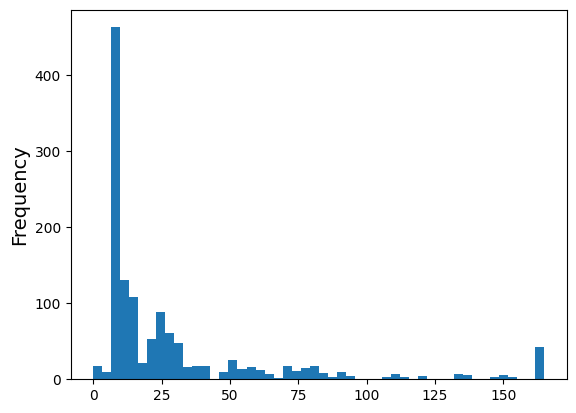

In [25]:
fare_cap = combined['Fare'].quantile(0.97)
combined['Fare'] = combined['Fare'].clip(upper=fare_cap)
combined.Fare.plot(kind="hist", bins=50)

# Feature Engineering

In this version I'll create a single feature of N_of_rel on titanic, which is SibSp+Parch.

In [26]:
# combined['n_of_rel'] = combined['SibSp'] + combined['Parch']
# combined = combined.drop(['SibSp', 'Parch'], axis=1)

# combined.head()

In [27]:
combined = combined.drop(['SibSp', 'Parch'], axis=1)
combined.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 8 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Survived    891 non-null    float64
 1   Pclass      1309 non-null   int64  
 2   Sex         1309 non-null   int64  
 3   Age         1309 non-null   float64
 4   Fare        1309 non-null   float64
 5   Embarked_C  1309 non-null   bool   
 6   Embarked_Q  1309 non-null   bool   
 7   Embarked_S  1309 non-null   bool   
dtypes: bool(3), float64(3), int64(2)
memory usage: 55.1 KB


# Feature Scaling
Previously I used standard scaler, but because some of the data is skewed, like fare price, I'll apply robust scaler.

In [28]:
from sklearn.preprocessing import RobustScaler

# Exclude survived from scaling and scale
cols_to_scale = combined.columns.drop("Survived")
rob_scale = RobustScaler()
combined_scaled = rob_scale.fit_transform(combined[cols_to_scale])

# Remerge
combined_final = pd.DataFrame(combined_scaled, columns=cols_to_scale)
combined_final['Survived'] = combined['Survived'].values

combined_final.head()

,Pclass,Sex,Age,Fare,Embarked_C,Embarked_Q,Embarked_S,Survived
0,0.0,0.0,-0.407672,-0.308146,0.0,0.0,0.0,0.0
1,-2.0,1.0,0.624586,2.430755,1.0,0.0,-1.0,1.0
2,0.0,1.0,-0.149607,-0.279274,0.0,0.0,0.0,1.0
3,-2.0,1.0,0.431038,1.652999,0.0,0.0,0.0,1.0
4,0.0,0.0,0.431038,-0.273927,0.0,0.0,0.0,0.0


# Training the Model!

In [29]:
# First, separate the training and test sets.

# Split based on NaN in Survived column
train_final = combined_final[combined_final['Survived'].notna()].copy()
test_final = combined_final[combined_final['Survived'].isna()].copy()

# For train set, convert Survived to int (it's probably float due to NaNs)
train_final['Survived'] = train_final['Survived'].astype(int)

# For test set, you probably want to drop the Survived column
test_final = test_final.drop('Survived', axis=1)

In [30]:
# Final dataset prep before training

x_train = train_final.drop("Survived", axis=1)
y_train = train_final["Survived"]
x_test = test_final

In [31]:
x_train.head()
#y_train.head()
#x_test.head()

,Pclass,Sex,Age,Fare,Embarked_C,Embarked_Q,Embarked_S
0,0.0,0.0,-0.407672,-0.308146,0.0,0.0,0.0
1,-2.0,1.0,0.624586,2.430755,1.0,0.0,-1.0
2,0.0,1.0,-0.149607,-0.279274,0.0,0.0,0.0
3,-2.0,1.0,0.431038,1.652999,0.0,0.0,0.0
4,0.0,0.0,0.431038,-0.273927,0.0,0.0,0.0


## Shortlisting models on k-fold cross validation scores

In [32]:
from sklearn.model_selection import cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

knn = KNeighborsClassifier(n_neighbors=5)
log = LogisticRegression(max_iter=1000, random_state=42)
rfc = RandomForestClassifier(n_estimators=100, random_state=42)
svm = SVC(kernel='rbf', random_state=42)
xgb = XGBClassifier(n_estimators = 100, random_state=42, eval_metric="logloss")

cv_scores_knn = cross_val_score(knn, x_train, y_train, cv=5, scoring='accuracy')
cv_scores_log = cross_val_score(log, x_train, y_train, cv=5, scoring='accuracy')
cv_scores_rfc = cross_val_score(rfc, x_train, y_train, cv=5, scoring='accuracy')
cv_scores_svm = cross_val_score(svm, x_train, y_train, cv=5, scoring='accuracy')
cv_scores_xgb = cross_val_score(xgb, x_train, y_train, cv=5, scoring='accuracy')

print(cv_scores_knn.mean(), cv_scores_knn.std())
print(cv_scores_log.mean(), cv_scores_log.std())
print(cv_scores_rfc.mean(), cv_scores_rfc.std())
print(cv_scores_svm.mean(), cv_scores_svm.std())
print(cv_scores_xgb.mean(), cv_scores_xgb.std())

0.8013684012303057 0.019407532676102672
0.7879040863724813 0.012015931710652192
0.8047266336074321 0.017752219446658776
0.8114493754315486 0.019310960384214423
0.8103508882053857 0.017951669180091712


## Finetuning
Not surprisingly, xgboost performs the best. I'll proceed to finetune it.

Well, change of results, now SVM is doing better on cross validation. I'll test xgboost first, and then maybe finetune svm in a new version.

In [33]:
from sklearn.model_selection import GridSearchCV

# From claude I got these parameters for finetuning
svm_params = {
    'C': [1, 10, 100],
    'gamma': ['scale', 0.01, 0.1],
    'kernel': ['rbf', 'linear']
}

# Run grid search
svm = SVC(random_state=42, probability=True)
svm_grid = GridSearchCV(
    svm, 
    svm_params, 
    cv=5, 
    scoring='accuracy',
    n_jobs=-1,
    verbose=1
)

svm_grid.fit(x_train, y_train)
print(f"Best params: {svm_grid.best_params_}")
print(f"Best score: {svm_grid.best_score_:.4f}")

Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best params: {'C': 10, 'gamma': 0.1, 'kernel': 'rbf'}
Best score: 0.8193


# Submission

In [34]:
# Predict on scaled test data
test_preds = svm_grid.predict(x_test)

# Build Kaggle submission file
submission = pd.DataFrame({
    "PassengerId": test['PassengerId'],
    "Survived": test_preds
})

# Save to CSV
submission.to_csv("submission.csv", index=False)
print("Submission file created: submission.csv")

Submission file created: submission.csv
